# GC + RSI Strategy Backtest
このノートブックでは、ゴールデンクロスにRSIフィルタを組み合わせた戦略のバックテスト手順をまとめます。

## 手順概要
1. ローソク足データを読み込みます（既存のCSV/Parquetキャッシュを利用）。
2. `add_gc_rsi_features` でSMA/RSI列を付与し、`run_backtest_gc_rsi` を実行します。
3. 結果サマリ・トレード明細・エクイティカーブを確認します。

In [1]:
from pathlib import Path
import pandas as pd

from gc_bot import (
    load_latest_cached_ccxt,
    add_gc_rsi_features,
    run_backtest_gc_rsi,
    GCAndRSIBacktestConfig,
    GCAndRSIStrategyParams,
)
import numpy as np

import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from gc_bot import CCXTConfig
from gc_bot import fetch_ohlcv_range_ccxt


In [2]:
# 1. データ読み込み: 過去1年のキャッシュ/取得
symbol = "XRP/JPY"
history_path = Path("../data/candles/xrpjpy_1h_history.parquet")
if history_path.exists():
    df = pd.read_parquet(history_path)
else:
    end_jst = pd.Timestamp.now(tz="Asia/Tokyo")
    start_jst = end_jst - pd.Timedelta(days=365)
    cfg_fetch = CCXTConfig(exchange_id="bitflyer", symbol=symbol, timeframe="1h", limit=200)
    df = fetch_ohlcv_range_ccxt(cfg_fetch, start=start_jst, end=end_jst, chunk_limit=200)
    history_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(history_path, index=True)

df = df.sort_index()
print(f"Loaded {len(df)} rows spanning {df.index.min()} - {df.index.max()}")

# 2. 戦略パラメータの定義（例: RSI >= 52 を条件とする）
strategy_params = GCAndRSIStrategyParams(rsi_period=14, min_rsi=52.0)
cfg = GCAndRSIBacktestConfig(strategy=strategy_params)

df_feat = add_gc_rsi_features(df.copy(), strategy_params)

# 3. バックテスト実行
result = run_backtest_gc_rsi(df, cfg)
display(result.summary)

# 4. トレード明細とエクイティカーブの表示例
trades_df = pd.DataFrame([t.to_dict() for t in result.trades])
trades_df.head()



Loaded 8760 rows spanning 2024-10-12 18:00:00+09:00 - 2025-10-12 17:00:00+09:00


{'trades': 56,
 'win': 42,
 'loss': 14,
 'win_rate': 75.0,
 'pnl_total': 1116.57,
 'pnl_per_trade': 19.94,
 'max_drawdown': 674.3,
 'max_drawdown_pct': 0.67,
 'capital_initial': 100000.0,
 'capital_final': 101116.57,
 'total_return_pct': 1.12,
 'sharpe_ratio': 1.368,
 'mean_trade_return': 0.004,
 'trade_return_std': 0.0218,
 'notional_fraction': None,
 'notional_static': 5000.0,
 'rsi_period': 14,
 'min_rsi': 52.0,
 'max_rsi': None}

,entry_ts,exit_ts,entry_price,exit_price,size,pnl_jpy,reason,duration_bars,entry_fee_jpy,exit_fee_jpy,notional_jpy
0,2024-10-21T19:00:00+09:00,2024-10-22T18:00:00+09:00,83.951955,81.392680,59.587653,-167.279961,SL,23,7.50375,7.274998,5000.0
1,2024-10-28T09:00:00+09:00,2024-10-29T16:00:00+09:00,78.979470,80.518780,63.339245,82.344977,TP,31,7.50375,7.649998,5000.0
2,2024-11-05T14:00:00+09:00,2024-11-06T09:00:00+09:00,77.818890,79.335580,64.283878,82.344977,TP,19,7.50375,7.649998,5000.0
3,2024-11-10T11:00:00+09:00,2024-11-10T14:00:00+09:00,87.003480,88.699178,57.497700,82.344977,TP,3,7.50375,7.649998,5000.0
4,2024-11-21T13:00:00+09:00,2024-11-21T21:00:00+09:00,172.986450,176.357956,28.918450,82.344977,TP,8,7.50375,7.649998,5000.0


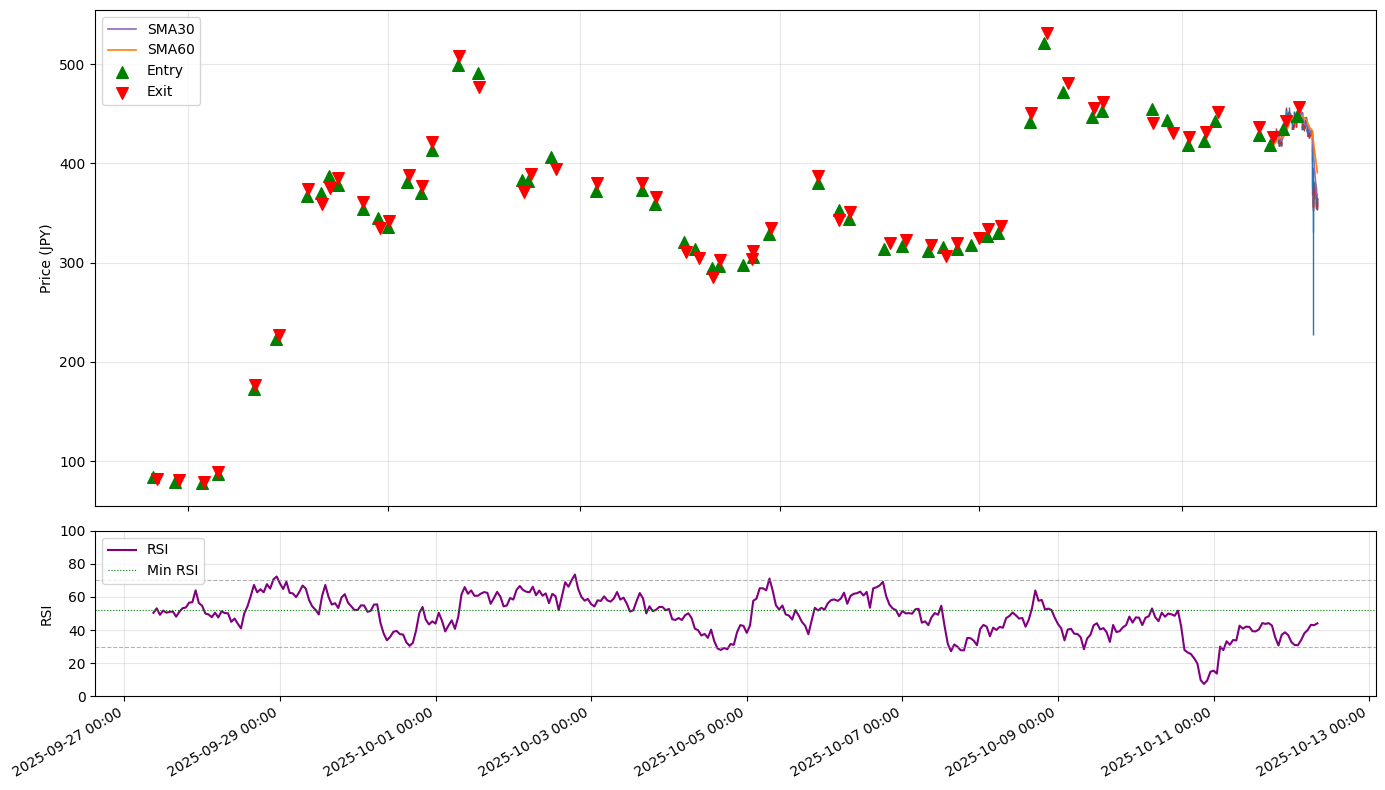

In [3]:
# 5. 可視化: ローソク足・SMA とトレードタイミング、RSI を重ねて表示
%matplotlib inline
import matplotlib.pyplot as plt

plot_data = df_feat.tail(360) if len(df_feat) > 360 else df_feat

if plot_data.empty:
    raise ValueError('plot_data is empty; ensure df_feat has rows before plotting')

fig, (ax_price, ax_rsi) = plt.subplots(
    2,
    1,
    figsize=(14, 8),
    sharex=False,
    gridspec_kw={"height_ratios": [3, 1]},
)

dates = plot_data.index
if dates.tz is None:
    dates = dates.tz_localize("Asia/Tokyo")
else:
    dates = dates.tz_convert("Asia/Tokyo")
plot_tz = dates.tz

date_nums = mdates.date2num(dates.to_pydatetime())
if len(dates) > 1:
    step_days = (dates[1] - dates[0]).total_seconds() / 86400.0
else:
    step_days = 1 / 24
bar_width = step_days * 0.6

opens = plot_data['open'].to_numpy()
highs = plot_data['high'].to_numpy()
lows = plot_data['low'].to_numpy()
closes = plot_data['close'].to_numpy()

for dnum, o, h, l, c in zip(date_nums, opens, highs, lows, closes):
    color = 'tab:red' if c >= o else 'tab:blue'
    ax_price.vlines(dnum, l, h, color=color, linewidth=1)
    body_bottom = min(o, c)
    body_height = max(abs(c - o), 1e-6)
    ax_price.add_patch(
        Rectangle(
            (dnum - bar_width / 2, body_bottom),
            bar_width,
            body_height,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    )

ax_price.plot(date_nums, plot_data['sma_short'], label=f"SMA{strategy_params.signal.short_window}", color='tab:purple', linewidth=1.2)
ax_price.plot(date_nums, plot_data['sma_long'], label=f"SMA{strategy_params.signal.long_window}", color='tab:orange', linewidth=1.2)

if not trades_df.empty:
    trades_plot = trades_df.copy()
    entry_ts = pd.to_datetime(trades_plot['entry_ts'], errors='coerce')
    exit_ts = pd.to_datetime(trades_plot['exit_ts'], errors='coerce')

    if getattr(entry_ts.dt, 'tz', None) is None:
        entry_ts = entry_ts.dt.tz_localize(plot_tz, nonexistent='shift_forward', ambiguous='NaT')
    else:
        entry_ts = entry_ts.dt.tz_convert(plot_tz)

    if getattr(exit_ts.dt, 'tz', None) is None:
        exit_ts = exit_ts.dt.tz_localize(plot_tz, nonexistent='shift_forward', ambiguous='NaT')
    else:
        exit_ts = exit_ts.dt.tz_convert(plot_tz)

    entry_mask = entry_ts.notna()
    exit_mask = exit_ts.notna()

    ax_price.scatter(
        mdates.date2num(entry_ts[entry_mask].dt.to_pydatetime()),
        trades_plot.loc[entry_mask, 'entry_price'],
        marker='^',
        color='green',
        s=70,
        label='Entry',
        zorder=5,
    )
    ax_price.scatter(
        mdates.date2num(exit_ts[exit_mask].dt.to_pydatetime()),
        trades_plot.loc[exit_mask, 'exit_price'],
        marker='v',
        color='red',
        s=70,
        label='Exit',
        zorder=5,
    )

ax_price.set_ylabel('Price (JPY)')
ax_price.legend(loc='upper left')
ax_price.grid(alpha=0.3)
ax_price.xaxis_date()
ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

ax_rsi.plot(date_nums, plot_data[strategy_params.rsi_column], color='purple', label='RSI')
ax_rsi.set_ylim(0, 100)
ax_rsi.set_ylabel('RSI')
ax_rsi.axhline(70, color='grey', linestyle='--', linewidth=0.8, alpha=0.6)
ax_rsi.axhline(30, color='grey', linestyle='--', linewidth=0.8, alpha=0.6)
if strategy_params.min_rsi is not None:
    ax_rsi.axhline(strategy_params.min_rsi, color='green', linestyle=':', linewidth=0.8, label='Min RSI')
if strategy_params.max_rsi is not None:
    ax_rsi.axhline(strategy_params.max_rsi, color='red', linestyle=':', linewidth=0.8, label='Max RSI')
ax_rsi.legend(loc='upper left')
ax_rsi.grid(alpha=0.3)
ax_rsi.xaxis_date()
ax_rsi.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

